<a href="https://colab.research.google.com/github/tnwls6865/Creative_Masters/blob/main/week9_re.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DCGAN (Fashion Generation)

In [1]:
import torch
use_gpu = True if torch.cuda.is_available() else False

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=use_gpu)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to /root/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/DCGAN_fashionGen-1d67302.pth" to /root/.cache/torch/hub/checkpoints/DCGAN_fashionGen-1d67302.pth
100%|██████████| 39.7M/39.7M [00:02<00:00, 14.5MB/s]


Average network found !


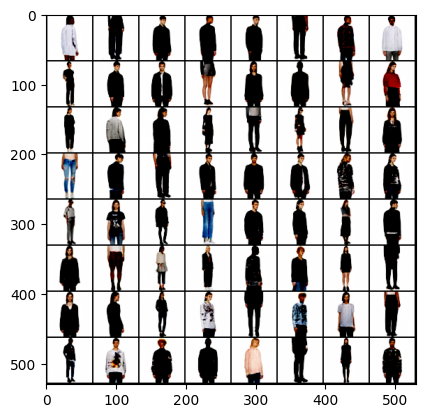

In [2]:
num_images = 64
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
plt.imshow(torchvision.utils.make_grid(generated_images).permute(1, 2, 0).cpu().numpy())
# plt.show()

## StyleGAN

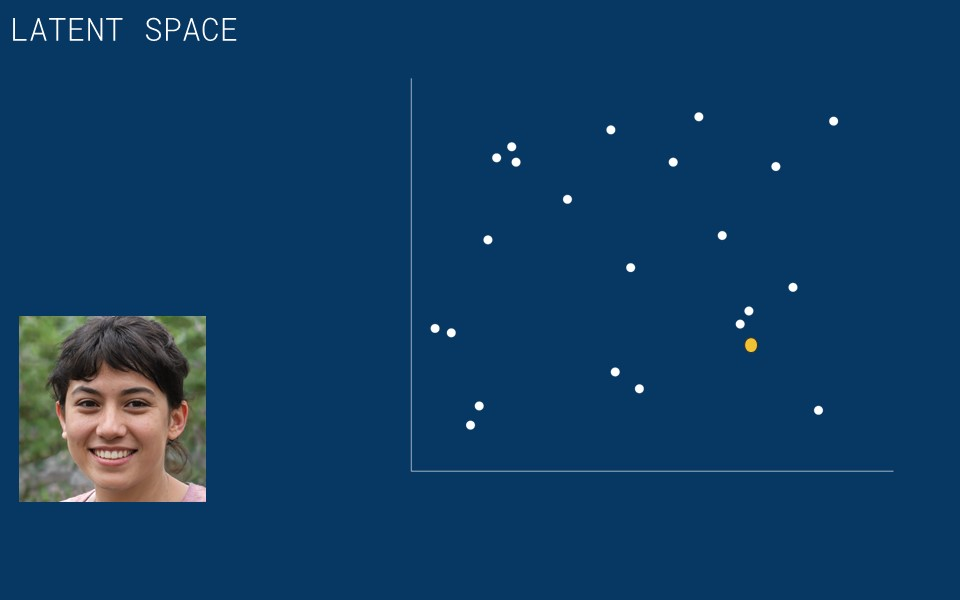

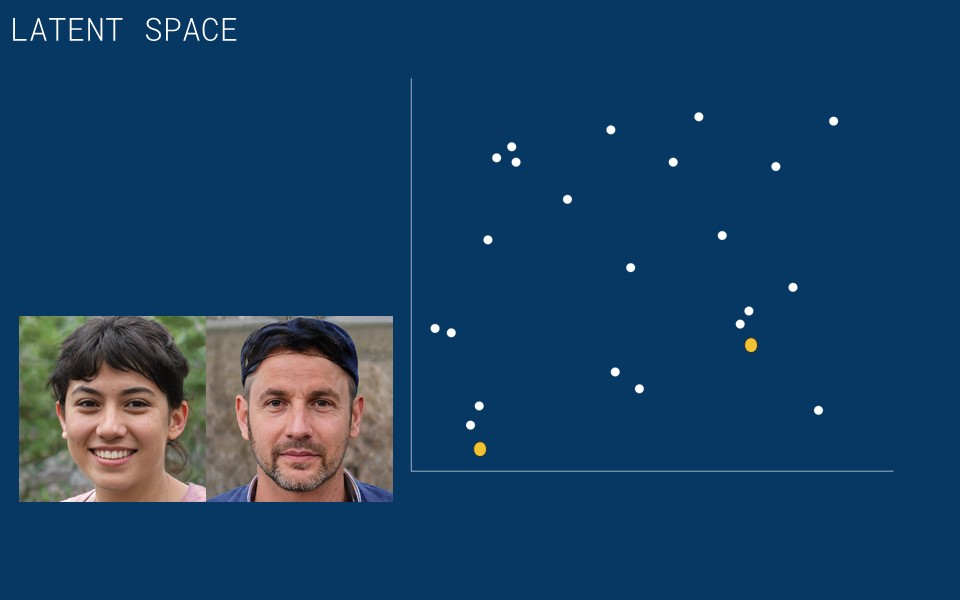

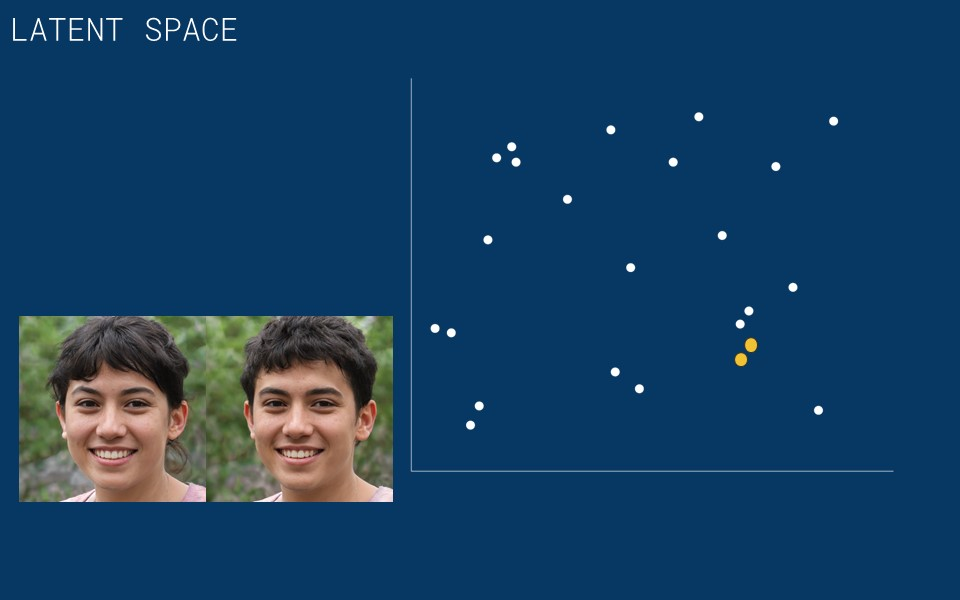

In [1]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1 -O models/pretrain/pggan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1 -O models/pretrain/stylegan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 613 (delta 94), reused 92 (delta 92), pack-reused 489
Receiving objects: 100% (613/613), 13.71 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (204/204), done.


In [2]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models.model_settings import MODEL_POOL
from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'pggan':
    generator = PGGANGenerator(model_name)
  elif gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

In [3]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "W" #@param ['Z', 'W']

generator = build_generator(model_name)

ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

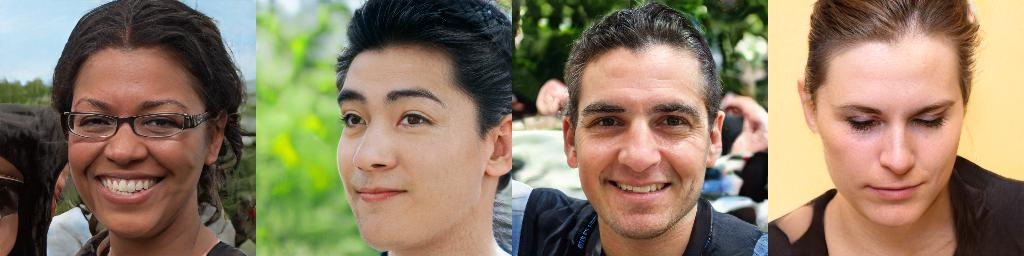

In [4]:
#@title { display-mode: "form", run: "auto" }

num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 146 #@param {type:"slider", min:0, max:1000, step:1}

latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

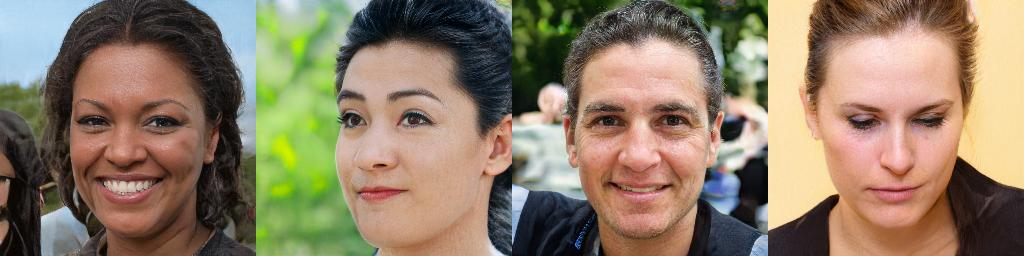

In [5]:
#@title { display-mode: "form", run: "auto" }

age = 1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = -1.8 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)

## Custom Training StyleGAN

## AnimeFACE GAN

In [6]:
from io import BytesIO
import torch
from PIL import Image
import urllib.request

import ipywidgets as widgets
import IPython.display as display
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load("bryandlee/animegan2-pytorch:main", "generator", device=device).eval()
face2paint = torch.hub.load("bryandlee/animegan2-pytorch:main", "face2paint", device=device)
image_format = "png"

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/bryandlee/animegan2-pytorch/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/bryandlee/animegan2-pytorch/raw/main/weights/face_paint_512_v2.pt" to /root/.cache/torch/hub/checkpoints/face_paint_512_v2.pt
100%|██████████| 8.20M/8.20M [00:00<00:00, 93.4MB/s]
Using cache found in /root/.cach

In [9]:
uploaded = files.upload()
for fname in uploaded:
    bytes_in = uploaded[fname]

    im_in = Image.open(BytesIO(bytes_in)).convert("RGB")
    im_out = face2paint(model, im_in, side_by_side=False)
    buffer_out = BytesIO()
    im_out.save(buffer_out, format=image_format)
    bytes_out = buffer_out.getvalue()
    wi1 = widgets.Image(value=bytes_in, format=image_format)
    wi2 = widgets.Image(value=bytes_out, format=image_format)
    wi1.layout.max_width = '500px'
    wi1.layout.max_height = '500px'
    wi2.layout.max_width = '500px'
    wi2.layout.max_height = '500px'

    ## Side by side thanks to HBox widgets
    sidebyside = widgets.HBox([wi1, wi2])
    ## Finally, show.
    display.display(sidebyside)

Saving 28003-1671435885.webp to 28003-1671435885 (2).webp


## Colorization

In [10]:
# Clone repo and install dependencies
%cd /content/
!git clone --recurse-submodules https://github.com/google-research/google-research.git
%cd google-research/coltran/
!pip install -r requirements.txt

/content
Cloning into 'google-research'...
remote: Enumerating objects: 70268, done.
remote: Counting objects: 100% (695/695), done.
remote: Compressing objects: 100% (500/500), done.
remote: Total 70268 (delta 293), reused 516 (delta 181), pack-reused 69573
Receiving objects: 100% (70268/70268), 373.74 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (43353/43353), done.
Updating files: 100% (17393/17393), done.
/content/google-research/coltran
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 46.7 MB/s eta 0:00:00
     ━━

In [11]:
# Download pre-trained model
!wget https://storage.googleapis.com/gresearch/coltran/coltran.zip -O coltran.zip
!unzip coltran.zip -d ./logdir

--2023-05-05 03:28:42--  https://storage.googleapis.com/gresearch/coltran/coltran.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 784621697 (748M) [application/zip]
Saving to: ‘coltran.zip’

coltran.zip         100%[===================>] 748.27M  20.0MB/s    in 38s     

2023-05-05 03:29:20 (19.9 MB/s) - ‘coltran.zip’ saved [784621697/784621697]

Archive:  coltran.zip
   creating: ./logdir/coltran/
   creating: ./logdir/coltran/spatial_upsampler/
   creating: ./logdir/coltran/colorizer/
   creating: ./logdir/coltran/color_upsampler/
  inflating: ./logdir/coltran/spatial_upsampler/checkpoint  
  inflating: ./logdir/coltran/spatial_upsampler/model-121.data-00000-of-00001  
  inflating: ./logdir/coltran/spatial_upsampler/model-121.index  
  inflating: ./logdir/coltran/col

In [20]:
# Set environment variables
 
import os
 
os.environ["LOGDIR"] = "/content/google-research/coltran/logdir/coltran"
!mkdir -p /content/input/ /content/output/
os.environ['IMG_DIR'] = "/content/input" 
os.environ['STORE_DIR'] = "/content/output"
 
mode = "recolorize" #@param ["recolorize", "colorize"]
os.environ['MODE'] = mode

In [21]:
# Run the colorizer to get a coarsely colorized image.
%cd /content/google-research/
!rm -rf $IMG_DIR/.ipynb_checkpoints/
!python -m coltran.custom_colorize --config=coltran/configs/colorizer.py --logdir=$LOGDIR/colorizer --img_dir=$IMG_DIR --store_dir=$STORE_DIR --mode=$MODE

/content/google-research
2023-05-05 03:42:07.848887: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0505 03:42:09.117714 140193356805952 deprecation.py:337] From /usr/local/lib/python3.10/dist-packages/tensorflow/python/training/moving_averages.py:548: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0505 03:42:09.414499 140193356805952 train_utils.py:91] Built with exponential moving average.
I0505 03:42:09.580166 140193356805952 train_utils.py:185] Restoring from /content/go

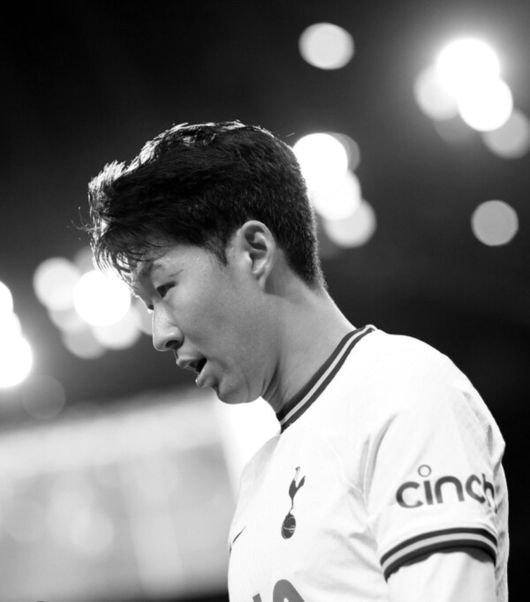

In [24]:
Image.open('/content/input/son_h.jpg')

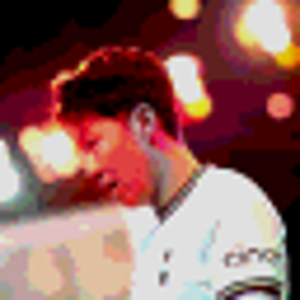

In [25]:
im = Image.open('/content/output/stage1/son_h.jpg')
im1 = im.resize((300, 300))
im1.show()

## FuseDream

In [26]:
!git clone https://github.com/gnobitab/FuseDream.git
!pip install ftfy regex tqdm numpy scipy h5py lpips==0.1.4
!pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!gdown 'https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM'
!gdown 'https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5'

Cloning into 'FuseDream'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 8.24 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 8.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ut4yz7_a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ut4yz7_a
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 

In [32]:
!cp biggan-256.pth FuseDream/BigGAN_utils/weights/
!cp biggan-512.pth FuseDream/BigGAN_utils/weights/
%cd FuseDream

cp: cannot stat 'biggan-256.pth': No such file or directory
cp: cannot stat 'biggan-512.pth': No such file or directory
[Errno 2] No such file or directory: 'FuseDream'
/content/google-research/FuseDream


In [33]:
import torch
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision
import BigGAN_utils.utils as utils
import clip
import torch.nn.functional as F
from DiffAugment_pytorch import DiffAugment
import numpy as np
from fusedream_utils import FuseDreamBaseGenerator, get_G, save_image

In [34]:
#@title { display-mode: "form", run: "auto" }
SENTENCE = "A photo of a blue dog." #@param {type:"string"}
INIT_ITERS =  100#@param {type:"number"}
OPT_ITERS = 100#@param {type:"number"}
NUM_BASIS = 5#@param {type:"number"}
MODEL = "biggan-256" #@param ["biggan-256","biggan-512"]
SEED = 42#@param {type:"number"}

import sys
sys.argv = [''] ### workaround to deal with the argparse in Jupyter

Generating: A photo of a blue dog.
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


AugCLIP score: 0.36075439453125


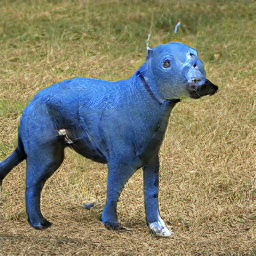

In [35]:
### Generation: Click the 'run' button and the final generated image will be shown after the end of the algorithm
utils.seed_rng(SEED) 

sentence = SENTENCE

print('Generating:', sentence)
if MODEL == "biggan-256":
    G, config = get_G(256) 
elif MODEL == "biggan-512":
    G, config = get_G(512) 
else:
    raise Exception('Model not supported')
generator = FuseDreamBaseGenerator(G, config, 10) 
z_cllt, y_cllt = generator.generate_basis(sentence, init_iters=INIT_ITERS, num_basis=NUM_BASIS)

z_cllt_save = torch.cat(z_cllt).cpu().numpy()
y_cllt_save = torch.cat(y_cllt).cpu().numpy()
img, z, y = generator.optimize_clip_score(z_cllt, y_cllt, sentence, latent_noise=False, augment=True, opt_iters=OPT_ITERS, optimize_y=True)
### Set latent_noise = True yields slightly higher AugCLIP score, but slightly lower image quality. We set it to False for dogs.
score = generator.measureAugCLIP(z, y, sentence, augment=True, num_samples=20)
print('AugCLIP score:', score)
import os
if not os.path.exists('./samples'):
    os.mkdir('./samples')
save_image(img, 'samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score))

from IPython import display
display.display(display.Image('samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score)))